In [1]:
%matplotlib inline
import numpy as np
import os
import pandas as pd

np.set_printoptions(precision=2)

#import utils; reload(utils)
#from utils import *


In [2]:
#path = "data/ml-20m/"
path = "../../"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Leitura dos Dados - Movielens dataset

- [Movielens - Readme](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
- Movielens - Small data set - 100.000 avaliações:[ml-latest-small.zip](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015).


In [3]:
import keras
from keras.utils.data_utils import get_file
dirname = 'mlens-latest-small'
origin = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
fpath = get_file(dirname,origin=origin,extract=True)

Using TensorFlow backend.


In [4]:
print(os.path.dirname(fpath))
#/Users/robertoalotufo/.keras/datasets/ml

/Users/robertoalotufo/.keras/datasets


In [5]:
ratings = pd.read_csv(os.path.dirname(fpath) + '/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
a = np.array([205, 205, 300, 205, 205, 300, 4])
index_inverse, ord_a = np.unique(a,return_inverse=True)
print('a:',a)
print('index_inverse:',index_inverse)
print('ord_a:',ord_a)
print(index_inverse[ord_a])

a: [205 205 300 205 205 300   4]
index_inverse: [  4 205 300]
ord_a: [1 1 2 1 1 2 0]
[205 205 300 205 205 300   4]


In [7]:
ratings = np.array(ratings)
n_samples = ratings.shape[0]
print(ratings.dtype,ratings.shape)
print('n_samples:',n_samples)

float64 (100004, 4)
n_samples: 100004


In [8]:
movieId = ratings[:,1].astype(np.int) # movieId em ordem qualquer com múltipla ocorrência
movieId_index_inverse,movieId_ord = np.unique(movieId,return_inverse=True)
n_movies = movieId_ord.max()+1
print('movieId (original):',movieId[:15])
print('movieId_ord (contínuo):',movieId_ord[:15])
print('n. de filmes:',n_movies)

movieId (original): [  31 1029 1061 1129 1172 1263 1287 1293 1339 1343 1371 1405 1953 2105 2150]
movieId_ord (contínuo): [  30  833  859  906  931 1017 1041 1047 1083 1087 1111 1140 1515 1665 1708]
n. de filmes: 9066


In [9]:
ratings_ordered = ratings[:,:3].copy()
ratings_ordered[:,1]=movieId_ord
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})
print(ratings_ordered[:5])

[[ 1.0  30.0  2.5]
 [ 1.0  833.0  3.0]
 [ 1.0  859.0  3.0]
 [ 1.0  906.0  2.0]
 [ 1.0  931.0  4.0]]


In [10]:
# verificando se os userIds estão ordenados
userId = ratings_ordered[:,0].astype(np.int)
userId_index_inverse, userId_ord = np.unique(userId,return_inverse=True)
n_users = userId_ord.max()+1
print('userId (original):',userId[:15])
print('userId_ord (contínuo):',userId_ord[:15])
print('n. de usuários:', n_users)

userId (original): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
userId_ord (contínuo): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
n. de usuários: 671


In [11]:
ratings_ordered[:,0]=userId_ord
print(ratings_ordered[:5])

[[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]]


Just for display purposes, let's read in the movie names too.

In [12]:
movie_names = pd.read_csv(os.path.dirname(fpath) + '/ml-latest-small/movies.csv')
movie_names[:5]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
mn = movie_names.set_index('movieId')
mn[:5]

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [14]:
mn['title'][:5]

movieId
1                      Toy Story (1995)
2                        Jumanji (1995)
3               Grumpier Old Men (1995)
4              Waiting to Exhale (1995)
5    Father of the Bride Part II (1995)
Name: title, dtype: object

In [15]:
mn_dic = mn.to_dict()
movieId = 30
print(mn_dic['genres'][movieId])
print(mn_dic['title'][movieId])

Crime|Drama
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)


In [16]:
user_min, user_max, movie_min, movie_max = (ratings_ordered[:,0].min(), 
                                            ratings_ordered[:,0].max(), 
                                            ratings_ordered[:,1].min(), 
                                            ratings_ordered[:,1].max())
user_min, user_max, movie_min, movie_max

(0.0, 670.0, 0.0, 9065.0)

In [17]:
n_users, n_movies, n_samples

(671, 9066, 100004)

This is the number of latent factors in each embedding.

In [18]:
n_factors = 50

In [19]:
np.random.seed = 42

Randomly split into training and validation.

In [20]:
msk = np.random.rand(n_samples) < 0.8
train = ratings_ordered[msk]
valid = ratings_ordered[~msk]
print('train:',train.shape[0],' amostras:\n',train[:5])
print('valid:',valid.shape[0],' amostras:\n',valid[:5])

train: 79882  amostras:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]]
valid: 20122  amostras:
 [[ 0.0  1083.0  3.5]
 [ 0.0  1962.0  2.5]
 [ 1.0  45.0  4.0]
 [ 1.0  140.0  3.0]
 [ 1.0  184.0  3.0]]


In [21]:
grid_train = -1. * np.ones((n_users,n_movies))
uId = (train[:,0]).astype(np.int)
mId = (train[:,1]).astype(np.int)
grid_train[uId,mId] = train[:,2]
print(grid_train.shape)

(671, 9066)


In [22]:
show_train = np.zeros((n_users,n_movies,3))
show_train[:,:,0] = np.where(grid_train == -1., 5., 0.  )
show_train[:,:,1] = np.where(grid_train == -1., 0., grid_train)
show_train[:,:,2] = np.where(grid_train == -1., 0., grid_train)


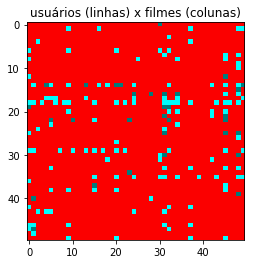

In [23]:
import matplotlib.pyplot as plt
plt.title('usuários (linhas) x filmes (colunas)')
#plt.xlabel('usuarios')
#plt.ylabel('filmes')
plt.imshow(show_train[:50,:50,:])
plt.show()

(array([ 892.0,  2668.0,  1352.0,  5753.0,  3519.0,  16042.0,  8404.0,
         23041.0,  6191.0,  12020.0]),
 array([ 0.5,  0.9,  1.4,  1.9,  2.3,  2.8,  3.2,  3.6,  4.1,  4.5,  5.0]),
 <a list of 10 Patch objects>)

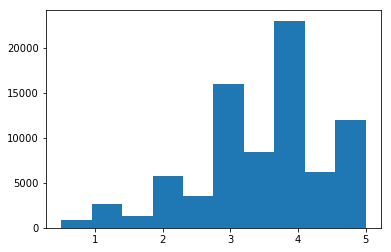

In [24]:
gt = grid_train.copy().reshape(-1)

plt.hist(gt[gt>=0])

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [25]:
# filmes melhores recomendados, maior soma dos ratings
gt[gt<0]=0.0
gt_2d = gt.reshape((n_users,n_movies))
best_movies = gt_2d.sum(axis=0)
i_best_movies = np.argsort(best_movies)[::-1]
print(i_best_movies[:10])
print(best_movies[i_best_movies[:10]])

[ 321  284  266  525  232  472 2062  953    0  427]
[ 1151.5  1144.5  1126.0  1037.0  989.0  861.5  853.0  820.0  806.0  801.5]


In [26]:
# usuários mais ativos, maior soma de ratings dados
best_users = gt_2d.sum(axis=1)
i_best_users = np.argsort(best_users)[::-1]
print(i_best_users[:10])
print(best_users[i_best_users[:10]])

[546 563  72 623  14 451 467  29 293 379]
[ 6426.0  5314.0  4443.5  3906.0  3647.0  3405.5  3035.0  2993.5  2797.0
  2782.0]


In [27]:
i_top_users = i_best_users[:10].astype(np.int)
i_top_movies = i_best_movies[:10].astype(np.int)
grid_train[i_top_users,:][:,i_top_movies]

array([[ 2.0,  5.0,  5.0,  5.0, -1.0, -1.0,  3.5,  2.5, -1.0,  3.0],
       [ 3.0, -1.0,  5.0,  5.0,  2.0,  4.0,  3.0,  5.0,  4.0,  5.0],
       [ 5.0,  5.0, -1.0,  4.5,  4.5, -1.0,  4.5,  5.0,  5.0, -1.0],
       [ 3.0, -1.0,  5.0,  5.0,  5.0, -1.0,  2.0,  5.0,  5.0,  3.0],
       [ 1.0,  2.0,  5.0,  5.0, -1.0,  4.0,  5.0,  5.0, -1.0,  3.0],
       [ 4.0,  5.0,  5.0,  5.0,  4.0,  4.0,  2.0,  4.0,  3.5,  5.0],
       [ 3.0, -1.0,  3.5, -1.0,  3.5, -1.0, -1.0,  3.0,  4.0,  2.5],
       [ 5.0,  5.0,  5.0,  4.0,  4.0,  5.0,  3.0,  4.0,  4.0,  4.0],
       [ 4.0,  3.0, -1.0, -1.0,  4.0, -1.0,  4.5,  4.0,  4.0,  4.0],
       [ 5.0,  4.0,  5.0,  5.0,  4.0, -1.0,  5.0,  4.0, -1.0,  4.0]])

In [ ]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [ ]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [ ]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [ ]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

In [ ]:
model.optimizer.lr=0.01

In [ ]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

In [ ]:
model.optimizer.lr=0.001

In [ ]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [ ]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [ ]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [ ]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [ ]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [ ]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [ ]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

In [ ]:
model.optimizer.lr=0.01

In [ ]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

In [ ]:
model.optimizer.lr=0.001

In [ ]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

In [ ]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [ ]:
model.save_weights(model_path+'bias.h5')

In [ ]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [ ]:
model.predict([np.array([3]), np.array([6])])

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [ ]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [ ]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [ ]:
sorted(movie_ratings, key=itemgetter(0))[:15]

In [ ]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

We can now do the same thing for the embeddings.

In [ ]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [ ]:
fac0 = movie_pca[0]

In [ ]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

In [ ]:
fac1 = movie_pca[1]

In [ ]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

In [ ]:
fac2 = movie_pca[2]

In [ ]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [ ]:
reload(sys)
sys.setdefaultencoding('utf8')

In [ ]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [ ]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [ ]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [ ]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

This improves on our already impressive accuracy even further!